In [25]:
# MO444-A 2s/2017 - Second assignment
#
#         Group 05
#
# - Anderson Rossanez (124136)
# - Bruno Branta Lopes (31470)
#

from __future__ import print_function
from copy import deepcopy
from datetime import datetime
from math import sqrt
from scipy import misc
from skimage.io import imread
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from numpy.linalg import norm
import tensorflow as tf
import glob
import random
import matplotlib.pyplot as plt
import numpy as np

# Some definitions
classes = np.asarray(['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
int_classes = preprocessing.LabelEncoder().fit_transform(classes) # [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
onehot_classes = onehot_encoder.fit_transform(int_classes.reshape(len(int_classes), 1))

def load_image_dataset(name, sample=1., as_gray=False):
    """Loads an image dataset
    name: directory in which dataset is defined
    sample: fraction of the dataset to be loaded [0, 1]
    as_gray: read images as grayscale to have a 32x32 matrix, instead of a 32x32x3 matrix in case of RGB.
    """
    random.seed(1)
    X, Y = [], []
    with open('cifar-10/%s/labels' % name) as labels:
        i = 0
        for path in sorted(glob.glob('cifar-10/%s/*.png' % name)):
            y = int(labels.next())
            if random.random() > sample:
                continue
            Y.append(y)
            X.append(imread(path, as_grey=as_gray))
    X, Y = np.array(X), np.array(Y)
    n_dim = reduce(lambda x, y: x * y, X.shape[1:])
    return X.reshape(-1, n_dim), Y

def display_image(x):
    """Prints a colored or grayscale 32x32 image"""
    colors = x.shape[0] / 32 / 32
    cmap = 'gray' if colors == 1 else 'jet'
    new_shape = (32, 32) if colors == 1 else (32, 32, colors)
    plt.imshow(x.reshape(new_shape), cmap=cmap)
    plt.show()

In [13]:
# Load train dataset
data_X, data_Y = load_image_dataset('train', as_gray=True, sample=1)
print("Loaded %d samples" % len(data_X))

Loaded 50000 samples


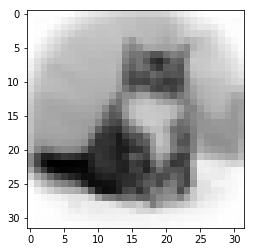

Label: cat


In [26]:
# Take a look at a sample and its class
display_image(data_X[207])

print('Label: %s' % classes[int(data_Y[207])])

In [15]:
# Implementing K-Fold to help avoiding overfitting
from sklearn.model_selection import KFold

def print_results(k, start_time, train_accuracy, train_precision, train_recall, train_f1, 
                  validation_accuracy, validation_precision, validation_recall, validation_f1):
    print('\nk={} time elapsed: {}'.format(k, datetime.now() - start_time))
    print('                Accuracy sd    Precision sd      Recall sd     F1 Score sd')
    print('Training:      %5.2f  ±%5.2f   %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(train_accuracy), np.std(train_accuracy), np.mean(train_precision), np.std(train_precision), np.mean(train_recall), np.std(train_recall), np.mean(train_f1), np.std(train_f1)))
    print('Validation:    %5.2f  ±%5.2f   %5.2f  ±%5.2f   %5.2f ±%5.2f    %5.2f ±%5.2f' % (
            np.mean(validation_accuracy), np.std(validation_accuracy), np.mean(validation_precision), np.std(validation_precision), np.mean(validation_recall), np.std(validation_recall), np.mean(validation_f1), np.std(validation_f1)))

def run_kfold(method, data_Y, data_X, scale=False, report_timeout_seconds=60, one_fold_test=False):
    # prepare for 5-fold execution
    random_state = np.random.RandomState(1)
    k5_fold = KFold(n_splits=5, shuffle=True, random_state=random_state)
    train_accuracy, train_precision, train_recall, train_f1 = [], [], [], []
    validation_accuracy, validation_precision, validation_recall, validation_f1 = [], [], [], []
    start_time = last_time = datetime.now()
    k = 0
    model = None

    for train_index, validation_index in k5_fold.split(data_X):
        k += 1
        print('k%d' % k, end=' ')
        
        train_data_X, train_data_Y = data_X[train_index], data_Y[train_index]
        validation_data_X, validation_data_Y = data_X[validation_index], data_Y[validation_index]
        
        if scale:
            model_scaler = preprocessing.StandardScaler()
            train_data_X = model_scaler.fit_transform(train_data_X)
            validation_data_X = model_scaler.transform(validation_data_X)

        # Train the model(s) using the training data
        model = method(train_data_X, train_data_Y)
        
        # Predict training data
        predicted_train_data_Y = model.predict(train_data_X)
        train_accuracy.append(accuracy_score(train_data_Y, predicted_train_data_Y))
        train_precision.append(precision_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_recall.append(recall_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        train_f1.append(f1_score(train_data_Y, predicted_train_data_Y, average='weighted'))
        
        # Predict validation data
        predicted_validation_data_Y = model.predict(validation_data_X)
        validation_accuracy.append(accuracy_score(validation_data_Y, predicted_validation_data_Y))
        validation_precision.append(precision_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_recall.append(recall_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        validation_f1.append(f1_score(validation_data_Y, predicted_validation_data_Y, average='weighted'))
        if one_fold_test:
            break
        if (datetime.now() - last_time).total_seconds() > report_timeout_seconds:
            print_results(k, start_time, train_accuracy, train_precision, train_recall, train_f1, validation_accuracy, validation_precision, validation_recall, validation_f1)
            
        last_time = datetime.now()
    
    print_results(k, start_time, train_accuracy, train_precision, train_recall, train_f1, validation_accuracy, validation_precision, validation_recall, validation_f1)
    
    return model

In [54]:
# One-vs-All logistic regression
class OvA_logistic_regression(object):
    
    def __init__(self, num_classes=len(classes), max_iter=10):
        self.num_classes = num_classes
        self.classifiers = []
        
        for i in xrange(self.num_classes):
            self.classifiers.append(LogisticRegression(solver='lbfgs', max_iter=max_iter))
        
    def fit(self, X, Y):
        for i in xrange(self.num_classes):
            y_curr_class = deepcopy(Y)
            curr_class_i = y_curr_class == i
            y_curr_class[curr_class_i] = 1
            y_curr_class[~curr_class_i] = 0
            loss = self.classifiers[i].fit(X, y_curr_class)
        
        return self

    def predict(self, X):
        num_classifiers = len(self.classifiers)
        predictions = np.zeros((num_classifiers, len(X)))
        for i in xrange(num_classifiers):
            predictions[i] = self.classifiers[i].predict(X)
            
        final_pred = np.argmax(predictions, axis=0)

        return final_pred

In [55]:
# Create a baseline One-vs-All logistic regression model
ova_lr_model = run_kfold(lambda X, Y: OvA_logistic_regression(max_iter=100).fit(X, Y), 
                         data_Y, data_X, scale=True)

k1 
k=1 time elapsed: 0:01:09.086938
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.15  ± 0.00    0.54  ± 0.00    0.15 ± 0.00     0.12 ± 0.00
Validation:     0.14  ± 0.00    0.36  ± 0.00    0.14 ± 0.00     0.10 ± 0.00
k2 
k=2 time elapsed: 0:02:20.110737
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.15  ± 0.00    0.54  ± 0.00    0.15 ± 0.00     0.12 ± 0.00
Validation:     0.14  ± 0.00    0.39  ± 0.03    0.14 ± 0.00     0.10 ± 0.00
k3 
k=3 time elapsed: 0:03:28.915857
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.15  ± 0.00    0.54  ± 0.00    0.15 ± 0.00     0.12 ± 0.00
Validation:     0.14  ± 0.00    0.38  ± 0.03    0.14 ± 0.00     0.10 ± 0.00
k4 
k=4 time elapsed: 0:04:43.244075
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.15  ± 0.00    0.54  ± 0.01    0.15 ± 0.00     0.12 ± 0.00
Validation:     0.14

In [56]:
# Create a Multinomial (Softmax) logistic regression model
mn_lr_model = run_kfold(lambda X, Y: LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=100).fit(X, Y), 
                        data_Y, data_X, scale=True)

k1 k2 k3 k4 k5 
k=5 time elapsed: 0:02:54.580477
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.34  ± 0.00    0.34  ± 0.00    0.34 ± 0.00     0.34 ± 0.00
Validation:     0.28  ± 0.00    0.27  ± 0.00    0.28 ± 0.00     0.27 ± 0.00


In [16]:
class Neural_Network(object):
    
    def __init__(self, input_size, output_size, hidden_layers=[3], learning_rate=0.1, epochs=10, 
                 activation_method='sigmoid', gradient_check=False):
        self.batch_size=10
        
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.activation_method = activation_method
        self.gradient_check = gradient_check

        self.input_size = input_size
        self.output_size = output_size
        
        self.layers_neurons = []
        self.layers_neurons.append(self.input_size)
        self.layers_neurons += hidden_layers
        self.layers_neurons.append(self.output_size)

        self.num_layers = len(self.layers_neurons) - 1

        self.thetas = {}
        self.biases = {}
        self.sums = {}
        self.activations = {}

        # Define this model's graph and enter its context
        self.our_graph = tf.Graph()
        self.set_our_graph_context()
        
        self.setup_nn()
        self.setup_cost()
        self.setup_optimizer()
        
        # define a tensorflow session and initialize the variables
        self.session = tf.Session()
        self.session.run(tf.global_variables_initializer())

    def set_our_graph_context(self):
        self.our_graph_context = self.our_graph.as_default()
        self.our_graph_context.enforce_nesting = False
        self.our_graph_context.__enter__()

    def setup_nn(self):
        # input and output placeholders
        self.x = tf.placeholder(tf.float32, [None, self.input_size], name='input')
        self.y = tf.placeholder(tf.float32, [None, self.output_size], name='output')

        for i in range(self.num_layers):
            self.thetas[i] = tf.Variable(tf.random_normal([self.layers_neurons[i], self.layers_neurons[i+1]], stddev=0.03), name='W%d'%(i))
            self.biases[i] = tf.Variable(tf.random_normal([self.layers_neurons[i+1]], stddev=0.03), name='b%d'%(i))

            self.sums[i] = tf.add(tf.matmul(self.x if i == 0 else self.activations[i-1], self.thetas[i]), self.biases[i])
            self.activations[i] = self.activation(self.sums[i])

        # Feeding forward operation with softmax at the end
        self.y_pred = tf.nn.softmax(self.activations[self.num_layers-1])
        
    def activation(self, x):
        if self.activation_method == 'sigmoid':
            return tf.div(tf.constant(1.0), tf.add(tf.constant(1.0), tf.exp(tf.negative(x))))
        if self.activation_method == 'tanh':
            return tf.tanh(x)
        if self.activation_method == 'relu':
            return tf.nn.relu(x)
        if self.activation_method == 'softplus':
            return tf.nn.softplus(x)
        if self.activation_method == 'softsign':
            return tf.nn.softsign(x)
        raise Exception('Invalid activation method: ' + repr(self.activation_method))
    
    def setup_cost(self):
        # Cost function (cross entropy)
        y_pred_clipped = tf.clip_by_value(self.y_pred, 1e-10, 0.9999999) # To avoid log(0), returning NaN
        self.cost = tf.reduce_mean(-tf.reduce_sum(self.y * tf.log(y_pred_clipped) + (1 - self.y) * tf.log(1 - y_pred_clipped), axis=1))

    def setup_optimizer(self):
        optimizer = tf.train.GradientDescentOptimizer(self.learning_rate)
        self.train = optimizer.minimize(self.cost)

    def check_gradients(self, feed_dict):
        all_grads = []
        all_num_grads = []
        for i in range(self.num_layers):
            w_tensor, b_tensor = self.thetas[i], self.biases[i]

            numgrads_w, grads_w = self.get_numerical_grad(w_tensor, feed_dict)
            all_num_grads += numgrads_w.tolist()
            all_grads += grads_w.tolist()
            
            numgrads_b, grads_b = self.get_numerical_grad(b_tensor, feed_dict)
            all_num_grads += numgrads_b.tolist()
            all_grads += grads_b.tolist()
        
        all_num_grads = np.asarray(all_num_grads)
        all_grads = np.asarray(all_grads)
        
        # Print a graph to compare original and calculated gradients
        plt.plot(all_num_grads, alpha=.5, label='num')
        plt.plot(all_grads, alpha=.5, label='orig')
        plt.ylabel('thethas & biases')
        plt.xlabel('grads')
        plt.legend()
        plt.show()

        return norm(all_grads - all_num_grads) / norm(all_grads + all_num_grads)
            
    def get_numerical_grad(self, var_tensor, feed_dict):
        grads = np.asarray(self.session.run(tf.gradients(self.cost, var_tensor), feed_dict)).ravel()
        original = self.session.run(var_tensor)
        
        # a flattened view of the original (change it, and you'll change the original)
        flattened = original.ravel()
        e = 1e-4

        num_grads = np.zeros(flattened.shape)
        for p in range(len(flattened)):
            # Do some perturbing
            original_flat_p = flattened[p]
            flattened[p] = original_flat_p + e
            self.session.run(tf.assign(var_tensor, original))
            loss2 = self.session.run(self.cost, feed_dict)

            flattened[p] = original_flat_p - e
            self.session.run(tf.assign(var_tensor, original))
            loss1 = self.session.run(self.cost, feed_dict)

            # Restore to original value
            flattened[p] = original_flat_p
            
            # Compute Numerical Gradient
            num_grads[p] = (loss2 - loss1) / (2 * e)
            # print('Loss 2:', loss2, 'Loss 1:', loss1, 'Num Grad:', num_grads[p], 'Grad:', grads[p]) # debug

        self.session.run(tf.assign(var_tensor, original))
        return num_grads, grads

    def fit(self, X, Y):
        self.set_our_graph_context() # Using this model's own graph.

        # Apply One Hot Encoding
        Y = onehot_encoder.transform(Y.reshape(len(Y), 1))

        costs = []
        ran_check = False
        for epoch in range(self.epochs):
            avg_cost = 0
            
            if self.gradient_check and epoch == self.epochs - 1 and ran_check == False:
                print('Gradient checking (this will take a while...)')
                start_time = datetime.now()
                check_value = self.check_gradients(feed_dict={self.x: X, self.y: Y})
                print('Time elapsed: {}. Gradient check result: {}'.format(datetime.now() - start_time, check_value))
                print('Is it around 1e-8?')
                ran_check = True
            else:
                for i in range(self.batch_size):
                    range_start = i * self.batch_size
                    range_end = (i + 1) * self.batch_size
                    feed_dict = {self.x: X[range_start:range_end], self.y: Y[range_start:range_end]}
                    
                    _, c = self.session.run([self.train, self.cost], feed_dict)
                    avg_cost += c / self.batch_size
                costs.append(avg_cost)

        self.print_costs(costs)
        return self

    def print_costs(self, costs):
        plt.plot(costs)
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.show()

    def predict(self, X):
        self.set_our_graph_context() # Using this model's own graph.

        # Forward propagation
        prediction = self.session.run(self.y_pred, feed_dict={self.x: X})
        return np.argmax(prediction, 1)
    
    def save(self, name):
        self.set_our_graph_context()
        saver = tf.train.Saver()
        saver.save(self.session, 'saved/' + name + '.nn.ckpt')
    
    def restore(self, name):
        self.set_our_graph_context()
        saver = tf.train.Saver()
        saver.restore(self.session, 'saved/' + name + '.nn.ckpt')

k1 Gradient checking (this will take a while...)


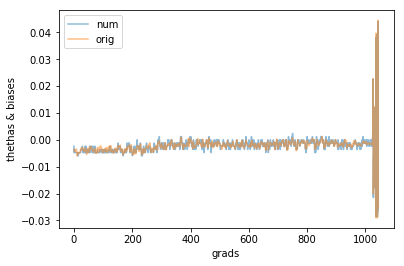

Time elapsed: 0:01:48.028575. Gradient check result: 0.0958083095225
Is it around 1e-8?


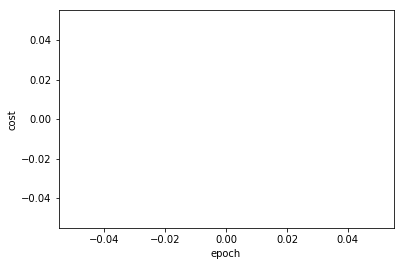


k=1 time elapsed: 0:01:48.340033
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.12  ± 0.00    0.02  ± 0.00    0.12 ± 0.00     0.03 ± 0.00
Validation:     0.00  ± 0.00    0.00  ± 0.00    0.00 ± 0.00     0.00 ± 0.00


In [11]:
# Simple neural network with a single hidden layer and a single neuron in it - to perform gradient checking
gc_data_X, gc_data_Y = [], []
num_class_types_in_sample = 2
for y, klass in enumerate(classes):
    index = np.flatnonzero(data_Y == y)
    index = np.random.choice(index, num_class_types_in_sample, replace=False)
    gc_data_X += data_X[index].tolist()
    gc_data_Y += data_Y[index].tolist()

nn_single_hl_model_one_neuron = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[1], 
                                               learning_rate=0.01, gradient_check=True, epochs=10, activation_method='tanh')
run_kfold(lambda X, Y: nn_single_hl_model_one_neuron.fit(X, Y), np.asarray(gc_data_Y), np.asarray(gc_data_X), one_fold_test=True)

In [48]:
activation_methods = ['sigmoid', 'tanh', 'relu', 'softplus', 'softsign']
hidden_layer_confs = [[32], [512], [1024], [1024, 32], [1024, 512], [1024, 1024]]
models = {}
for activation_method in activation_methods:
    models[activation_method] = {}
    for i, hidden_layer_conf in enumerate(hidden_layer_confs):
        name = '%s_%d' % (activation_method, i+1)
        print('\n*** Testing activation method:', activation_method, ', hidden layer conf: ', i+1, hidden_layer_conf)
        nn_model = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), 
                                  hidden_layers=hidden_layer_conf, learning_rate=.01, epochs=20000,
                                  activation_method=activation_method)
        nn_model.restore(name)
        models[activation_method][i] = \
            run_kfold(lambda X, Y: nn_model.fit(X, Y), data_Y, data_X, one_fold_test=True)
        nn_model.save(name)


*** Testing activation method: sigmoid , hidden layer conf:  1 [32]
INFO:tensorflow:Restoring parameters from saved/sigmoid_1.nn.ckpt


Exception AssertionError: AssertionError("Nesting violated for default stack of <class 'tensorflow.python.framework.ops.Graph'> objects",) in <generator object get_controller at 0x7f78642502d0> ignored



*** Testing activation method: sigmoid , hidden layer conf:  2 [512]
INFO:tensorflow:Restoring parameters from saved/sigmoid_2.nn.ckpt

*** Testing activation method: sigmoid , hidden layer conf:  3 [1024]
INFO:tensorflow:Restoring parameters from saved/sigmoid_3.nn.ckpt

*** Testing activation method: sigmoid , hidden layer conf:  4 [1024, 32]
INFO:tensorflow:Restoring parameters from saved/sigmoid_4.nn.ckpt

*** Testing activation method: sigmoid , hidden layer conf:  5 [1024, 512]
INFO:tensorflow:Restoring parameters from saved/sigmoid_5.nn.ckpt

*** Testing activation method: sigmoid , hidden layer conf:  6 [1024, 1024]
INFO:tensorflow:Restoring parameters from saved/sigmoid_6.nn.ckpt

*** Testing activation method: tanh , hidden layer conf:  1 [32]
INFO:tensorflow:Restoring parameters from saved/tanh_1.nn.ckpt

*** Testing activation method: tanh , hidden layer conf:  2 [512]
INFO:tensorflow:Restoring parameters from saved/tanh_2.nn.ckpt

*** Testing activation method: tanh , hid

k1 

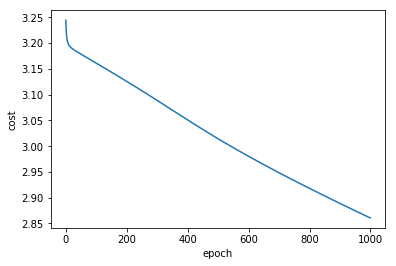

k2 

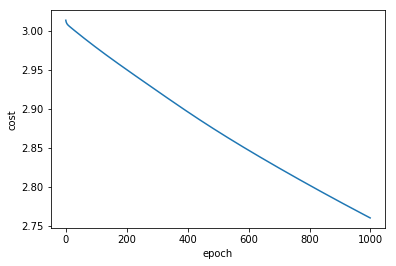

k3 

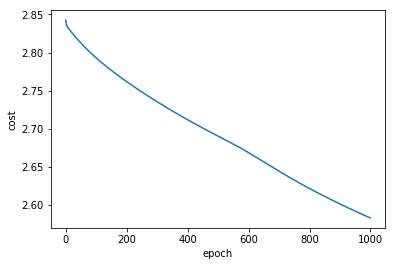

k4 

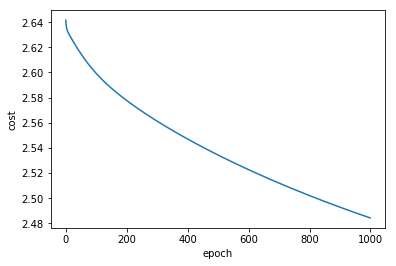

k5 

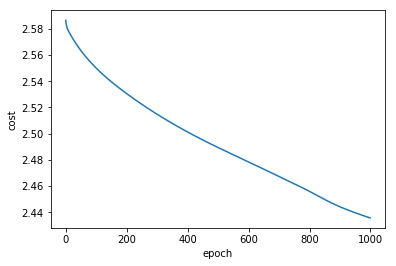


k=5 time elapsed: 0:02:25.140804
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.18  ± 0.01    0.22  ± 0.02    0.18 ± 0.01     0.16 ± 0.02
Validation:     0.18  ± 0.01    0.20  ± 0.01    0.18 ± 0.01     0.16 ± 0.02


In [11]:
# Neural Network with a single hidden layer
nn_single_hl_model = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[1024],  learning_rate=0.01, epochs=1000)
run_kfold(lambda X, Y: nn_single_hl_model.fit(X, Y), data_Y, data_X, report_timeout_seconds=120)

k1 

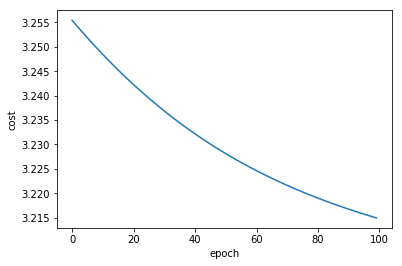

k2 

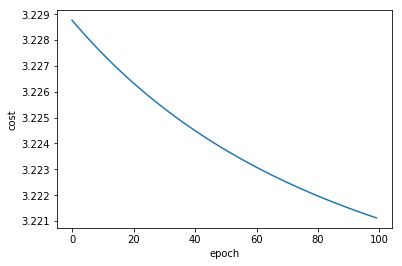

k3 

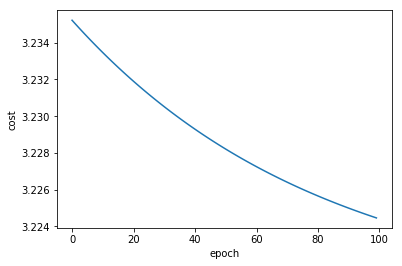

k4 

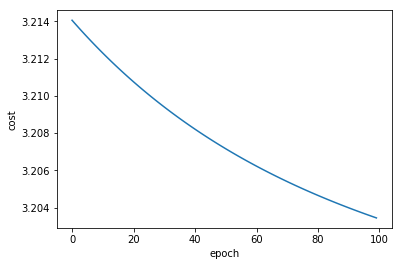

k5 

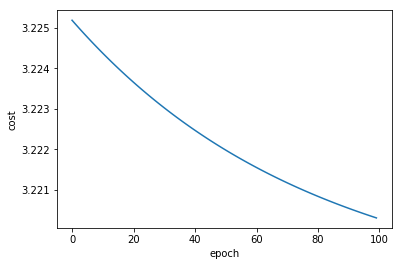


k=5 time elapsed: 0:00:06.131469
                Accuracy sd    Precision sd      Recall sd     F1 Score sd
Training:       0.10  ± 0.00    0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00
Validation:     0.10  ± 0.00    0.01  ± 0.00    0.10 ± 0.00     0.02 ± 0.00


In [12]:
# Neural Network with two hidden layers
nn_two_hl_model = Neural_Network(input_size=len(data_X[0]), output_size=len(classes), hidden_layers=[30, 30],  learning_rate=0.01, epochs=100)
run_kfold(lambda X, Y: nn_two_hl_model.fit(X, Y), data_Y, data_X, report_timeout_seconds=120)

In [13]:
# TODO: carry on with the testing (change activation functions, num_layers, num_neurons, etc...)

In [30]:
# Load test dataset (untouched so far)
test_X, test_Y = load_image_dataset('test', as_gray=True)
print("Loaded %d samples" % len(data_X))

Loaded 50000 samples


In [57]:
# Predict the test data using our chosen model
elected_model = mn_lr_model # models['relu'][2]
pred_test_Y = elected_model.predict(test_X)

In [61]:
# Confusion matrix
100. * confusion_matrix(test_Y, pred_test_Y) / len(test_Y)

array([[ 8.34,  0.  ,  0.02,  0.06,  0.01,  0.09,  0.01,  0.01,  1.43,
         0.03],
       [ 5.19,  0.51,  0.14,  0.18,  0.03,  0.15,  0.04,  0.08,  3.3 ,
         0.38],
       [ 8.52,  0.  ,  0.13,  0.13,  0.01,  0.17,  0.05,  0.01,  0.94,
         0.04],
       [ 7.32,  0.06,  0.19,  0.43,  0.04,  0.51,  0.08,  0.07,  1.21,
         0.09],
       [ 8.57,  0.  ,  0.19,  0.22,  0.06,  0.25,  0.04,  0.08,  0.58,
         0.01],
       [ 7.76,  0.01,  0.1 ,  0.17,  0.  ,  0.68,  0.06,  0.11,  1.09,
         0.02],
       [ 7.62,  0.05,  0.08,  0.3 ,  0.03,  0.29,  0.12,  0.04,  1.45,
         0.02],
       [ 7.64,  0.01,  0.19,  0.15,  0.01,  0.26,  0.01,  0.37,  1.28,
         0.08],
       [ 5.94,  0.02,  0.04,  0.09,  0.02,  0.11,  0.01,  0.05,  3.65,
         0.07],
       [ 5.47,  0.12,  0.03,  0.06,  0.01,  0.08,  0.03,  0.08,  3.36,
         0.76]])

In [62]:
test_accuracy = accuracy_score(test_Y, pred_test_Y)
test_precision = precision_score(test_Y, pred_test_Y, average='weighted')
test_recall = recall_score(test_Y, pred_test_Y, average='weighted')
test_f1 = f1_score(test_Y, pred_test_Y, average='weighted')

print('Test accuracy:  %5.2f' % test_accuracy)
print('Test precision: %5.2f' % test_precision)
print('Test recall:    %5.2f' % test_recall)
print('Test F1 Score:  %5.2f' % test_f1)

Test accuracy:   0.15
Test precision:  0.30
Test recall:     0.15
Test F1 Score:   0.10
